In [2]:
from ecell4 import *
%matplotlib inline
import numpy as np
import math
import sys
from math import sqrt
import matplotlib.pyplot as plt
from ecell4.extra import ensemble
import numpy as np
from math import pi
from scipy.optimize import curve_fit

def runodeirr(kf,phit,phi,L,run,duration):
    import numpy as np
    rm=0.005
    D=1.
    if phi<0.77:
        Deff=D*(1-phi/0.77)
    else: Deff=0
    print('Deff',Deff)
    R=2*rm
    f=1.0208582         
    rv=rm*f 
    td =(2*rv)**2/(6*D)   
    kD=4*math.pi*R*Deff*2
    kb=kf*4*math.pi*R*D*2
    w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),rv)
    size=tuple(w.calculate_shape(Real3(L,L,L),rv))    
    Nev = size[0]*size[1]*size[2]
    kbeff=kb*kD/(kb+kD)
    with reaction_rules():
        E+S >ES | kbeff/L**3

    m1=get_model()   
    NS=int(Nev*phit)
    NE=int(NS/5)   
    print('N',NS,NE,Nev)
    print('kon',kbeff)
    duration = td*duration
    #TT=np.linspace(1e-5,duration,1000)
    TT=np.logspace(-5,np.log10(0.02),1000)
    obs=run_simulation(TT, model=m1, y0={'S': NS, 'E': NE},return_type='array')
    obs=np.array(obs)
    dat=obs.T   
    return dat

def getrate(Ns,Ne,T):
    dst = (Ns[2:]-Ns[:-2])/(T[2:]-T[:-2])
    dst=np.append((Ns[1]-Ns[0])/(T[1]-T[0]),dst)
    dst=np.append(dst,(Ns[-1]-Ns[-2])/(T[-1]-T[-2])  )    
    rate = -dst/Ns
    rate=rate/Ne
    return T,rate

def latkt(t,kon,B):
    return kon * (1 + B / np.sqrt(t))


V 1.0 1.046275242466003
initial Ns1390.0Ne278.0,last Ns1113.39Ne1.39tti0.000ttend0.020
kon 0.22847946571562133 0.003626748003649389
Deff 1.0
N 1390 278 1390800
kon 0.22847946571562133
V 1.0 1.046275242466003
initial Ns1390.0Ne278.0,last Ns1119.90Ne7.90tti0.000ttend0.020
kon 0.14458247708075428 0.004812549040755852
Deff 0.6103896103896105
N 1390 278 1390800
kon 0.14458247708075428
V 1.0 1.046275242466003
initial Ns1390.0Ne278.0,last Ns1140.08Ne28.08tti0.000ttend0.020
kon 0.08514228521648624 0.006508875283426016
Deff 0.35064935064935066
N 1390 278 1390800
kon 0.08514228521648624
V 1.0 1.046275242466003
initial Ns1390.0Ne278.0,last Ns1227.65Ne115.65tti0.000ttend0.020
kon 0.022642109215061584 0.013112216601894931
Deff 0.09090909090909094
N 1390 278 1390800
kon 0.022642109215061584
V 1.0 1.046275242466003
initial Ns1390.0Ne278.0,last Ns1336.67Ne224.67tti0.000ttend0.020


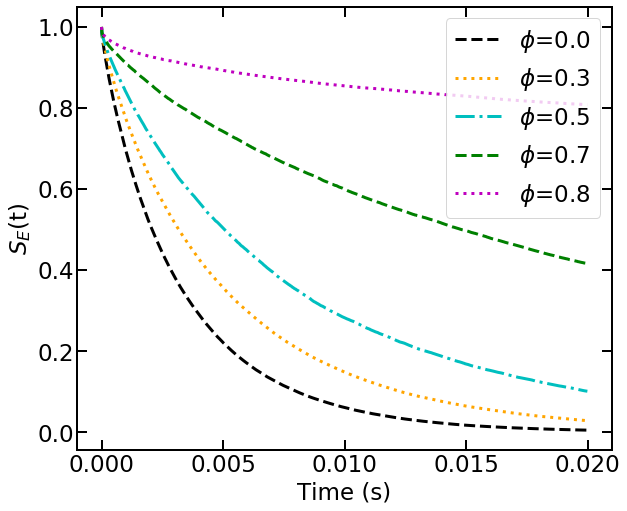

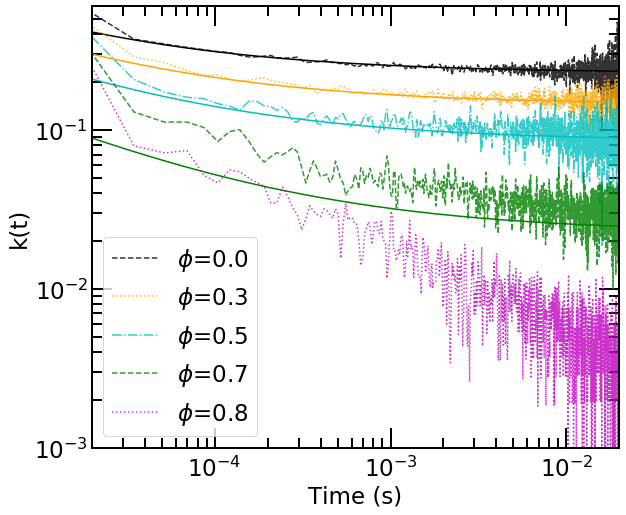

In [4]:
from cycler import cycler
dur=5e4
kf=10.
R=0.01
rm=R/2
D=1.
ka=kf*4*math.pi*R*D*2
run=1
f=1.0208582         

plt.tight_layout()
fig1,ax1=plt.subplots(1,1,figsize=(8.6,7))
fig2,ax2=plt.subplots(1,1,figsize=(8.6,7))
fs=23
ms=16
lw=3
cs = ['k','orange','c','g', 'm']
lss = ['--',':','-.','--',':']

def plotsim(phi,phit,L,ds,ode,i):
    ls = lss[i]
    vol=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),f*rm)
    print('V',L**3,vol)    
    name='/home/chew/wrk/ecellwork/MLM/data/3Dirxncrowding_kf10.0_phi{}phit{}L{}_Nratio5'.format(phi,phit,L)
    dat=np.genfromtxt(name,delimiter=',').T
    tt=dat[0][0::ds]
    Ne=dat[2][0::ds]
    idx=Ne>0
    Ns=dat[1][0::ds]
    tt=tt[idx]
    Ne=Ne[idx]
    Ns=Ns[idx]
    Ns0=Ns[0]
    Ne0=Ne[0]
    print('initial Ns{}Ne{},last Ns{:.2f}Ne{:.2f}tti{:.3f}ttend{:.3f}'.format(Ns0,Ne0,Ns[-1],Ne[-1],tt[0],tt[-1]))
    ax1.plot(tt,Ne/Ne0,c=cs[i],label='$\phi$={}'.format(phi),linewidth=lw,linestyle=ls)
    T,KT=getrate(Ns,Ne/vol,tt)
    ax2.plot(T,KT,'--',c=cs[i],label='$\phi$={}'.format(phi),alpha=0.8,linestyle=ls)
    if ode==1 and phi<0.77:
        Deff=D*(1-phi/0.77)
        kd=4*math.pi*R*Deff*2
        kon = (ka*kd)/(ka+kd)
        aeff = ka * (R) / (ka + kd)
        Bck = aeff/math.sqrt(2*Deff*math.pi)   
        print('kon',kon,Bck)
        tt,Ne,Nes,Ns=runodeirr(kf,phit,phi,L,run,dur) 
        Ns0=Ns[0]
        Ne0=Ne[0]
        t2,rate=getrate(Ns,Ne/L**3,tt)
        kth = latkt(t2,kon,Bck)
        ax2.plot(t2,kth,'-',c=cs[i])#,label='theory'+str(phi),linewidth=lw)           
DS=1
for i,phi in enumerate([0.0,0.3,0.5,0.7,0.8]):
    plotsim(phi,0.001,1.0,1,1,i)
ax1.set_ylabel('$S_E$(t)',fontsize=fs)
ax1.set_xlabel('Time (s)',fontsize=fs)
ax1.legend(loc='best',fontsize=fs)
ax1.tick_params(labelsize=fs)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylabel('k(t)',fontsize=fs)
ax2.set_xlabel('Time (s)',fontsize=fs)
ax2.legend(loc='best',fontsize=fs)
ax2.tick_params(labelsize=fs)
ax2.set_xlim(2e-5,0.02)
ax2.set_ylim(1e-3,0.6)
fig1.tight_layout(pad=0)
fig2.tight_layout(pad=0)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(axis='both',which='both',direction='in',length=10,width=2)
for axis in ['top','bottom','left','right']:
      ax1.spines[axis].set_linewidth(2)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.tick_params(axis='both',which='both',direction='in',length=10,width=2)
ax2.tick_params(axis='both',which='major',length=20,width=2)
ax2.tick_params(axis='x',which='major',pad=8)
for axis in ['top','bottom','left','right']:
      ax2.spines[axis].set_linewidth(2)        
